In [403]:
# Imports
import requests
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup as bs
import re
from stop_words import sw
from utils import *
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Define the url and the BeatifulSoup parser

In [404]:
URL = "https://en.wikipedia.org/wiki/Racing_Club_de_Avellaneda"

html = requests.get(URL).text
soup = bs(html, features="html.parser")

In [405]:
# Agrego div content
divContent = soup.find("div",{"id":"content"})

In [406]:
# Get all text from div with id="content"
text = divContent.get_text()
# separate all words separetly
wordsFromText = re.split(" |,|\n|\[|\]",text)
listOfWordsFiltered = list(filter(lambda word:
                                  isValidWord(word)
                                  ,wordsFromText))
listOfWordsFiltered[0:10]

['Racing',
 'Club',
 'de',
 'Avellaneda',
 'Wikipedia',
 'free',
 'encyclopedia',
 'Jump',
 'navigation',
 'Jump']

In [407]:
# Initialize vectorizer with one gram words
vectorizer = CountVectorizer(stop_words='english',lowercase=False)
X = vectorizer.fit_transform(listOfWordsFiltered)
featuresNames = vectorizer.get_feature_names()

## First approach will be find the words with most appearence

In [408]:
wordsAndAppearences = {}
for word in listOfWordsFiltered:
    wordsAndAppearences[word] = 1+wordsAndAppearences.get(word,0)

sortedWords = list(filter(lambda word: word != '' and word in featuresNames,sorted(wordsAndAppearences, key=wordsAndAppearences.get, reverse=True)))
print(sortedWords[0:15])

['Racing', 'Copa', 'Juan', 'FW', 'team', 'Argentina', 'MF', 'Juniors', 'Club', 'club', 'DF', 'league', 'Boca', 'title', 'year']


## Second approach will be pounder the apperence depending on wich element of the html were them

In [409]:
linkWordsDicc = {}
boldWordsDicc = {}
italicWordsDicc = {}
regularWordsDicc = {}
headersOneWordsDicc = {}
headersTwoWordsDicc = {}
headersThreeWordsDicc = {}
headersFourWordsDicc = {}
headersFiveWordsDicc = {}
headersSixWordsDicc = {}

def getDiccForTag(tag = ""):
    if tag == "i":
        return italicWordsDicc
    if tag == "b":
        return boldWordsDicc
    if tag == "a":
        return linkWordsDicc
    return regularWordsDicc

# First i will get all the content inside headers type tags and also keep track
# the ones that are also inside an italic tag or bold tag or link tag

headersOne = divContent.find_all("h1")
headersTwo = divContent.find_all("h2")
headersThree = divContent.find_all("h3")
headersFour = divContent.find_all("h4")
headersFive = divContent.find_all("h5")
headersSix = divContent.find_all("h6")

def extractDataFromElementWithTag(elementParent, tag):
    elements = elementParent.find_all(tag)
    words = []
    for elementText in elements:
        for word in elementText.get_text().split(" "):
            if isValidWord(word):
                dicc = getDiccForTag(tag)
                words.append(word)
                dicc[word] = dicc.get(word,0)+1
    return words

def extractDataFromHeaderAndSave(headerInfo, headerDicc):
    for header in headerInfo:
        extractDataFromElementWithTag(header,"i")
        extractDataFromElementWithTag(header,"a")
        bold = extractDataFromElementWithTag(header,"b")
        if len(bold) > 0 : print(bold)

        headersWordsExtraxted = list(filter(lambda word : isValidWord(word),re.split(" |,|\[|\]|–",header.get_text())))
        for word in headersWordsExtraxted:
            headerDicc[word] = headerDicc.get(word,0)+1

        # I will no longer need it
        header.extract()

extractDataFromHeaderAndSave(headersOne,headersOneWordsDicc)
extractDataFromHeaderAndSave(headersTwo,headersTwoWordsDicc)
extractDataFromHeaderAndSave(headersThree,headersThreeWordsDicc)
extractDataFromHeaderAndSave(headersFour,headersFourWordsDicc)
extractDataFromHeaderAndSave(headersFive,headersFiveWordsDicc)
extractDataFromHeaderAndSave(headersSix,headersSixWordsDicc)


In [410]:
def extractDataFromItalic(element):
    extractDataFromElementWithTag(element,"a")
    bold = extractDataFromElementWithTag(element,"b")

    italicWordsExtracted = list(filter(lambda word : isValidWord(word),re.split(" |,|\[|\]|–",element.get_text())))
    for word in italicWordsExtracted:
        dicc = getDiccForTag("i")
        dicc[word] = dicc.get(word,0)+1

    # I will no longer need it
    element.extract()

italics = divContent.find_all("i")
for italic in italics:
    extractDataFromItalic(italic)

In [411]:

# I will get all the link tags contents(<a></a>)

def extractDataFromLink(element):
    extractDataFromElementWithTag(element,"i")
    bold = extractDataFromElementWithTag(element,"b")

    linkWordsExtracted = list(filter(lambda word : isValidWord(word),re.split(" |,|\[|\]|–",element.get_text())))
    for word in linkWordsExtracted:
        dicc = getDiccForTag("a")
        dicc[word] = dicc.get(word,0)+1

    # I will no longer need it
    element.extract()

links = divContent.find_all("a")
for link in links:
    extractDataFromLink(link)

In [412]:
# Now i will parse all the rest of the document

def extractDataFromElement(element):
    extractDataFromElementWithTag(element,"i")
    bold = extractDataFromElementWithTag(element,"b")

    regularWordsExtracted = list(filter(lambda word : isValidWord(word),re.split(" |,|\[|\]|\n",element.get_text())))
    for word in regularWordsExtracted:
        dicc = getDiccForTag(element.tag)
        dicc[word] = dicc.get(word,0)+1

    # I will no longer need it
    element.extract()

restOfElements = divContent.find_all()
for element in restOfElements:
    extractDataFromElement(element)

In [413]:
# h1
# a
# b
# h2
# h3
# italic
# h4
# h5
# h6

featuresNamesHotOneEnconding = []

for featuresName in featuresNames:
    listWord = []
    listWord.append(featuresName)
    listWord.append(headersOneWordsDicc.get(featuresName,0))
    listWord.append(linkWordsDicc.get(featuresName,0))
    listWord.append(boldWordsDicc.get(featuresName,0))
    listWord.append(headersTwoWordsDicc.get(featuresName,0))
    listWord.append(headersThreeWordsDicc.get(featuresName,0))
    listWord.append(italicWordsDicc.get(featuresName,0))
    listWord.append(headersFourWordsDicc.get(featuresName,0))
    listWord.append(headersFiveWordsDicc.get(featuresName,0))
    listWord.append(headersSixWordsDicc.get(featuresName,0))
    listWord.append(regularWordsDicc.get(featuresName,0))
    featuresNamesHotOneEnconding.append(listWord)

df = pd.DataFrame(featuresNamesHotOneEnconding, columns=['word','h1','a','b','h2','h3','i','h4','h5','h6','regular'])

def f(n):
    a, b = 0, 1
    for i in range(0, n):
        a, b = b, a + b
    return a

def weightForVariables():
    weights = [f(x) for x in range(1,11)][::-1]
    return weights

def getScore(oneCodingForWord):
    return sum(a * b for a, b in zip(weightForVariables(), oneCodingForWord))

df['score'] = df.apply(lambda x: getScore([int(x['h1']),int(x['a']),int(x['b']),int(x['h2']),int(x['h3']),int(x['i']),int(x['h4']),int(x['h5']),int(x['h6']),int(x['regular'])]), axis=1)

df = df.sort_values(by=['score'],ascending=False)
df.head(20)

,word,h1,a,b,h2,h3,i,h4,h5,h6,regular,score
260,ARG,0,37,0,0,0,0,0,0,0,0,1258
409,Copa,0,35,0,0,0,0,0,0,0,31,1221
766,Racing,1,17,8,0,0,0,0,0,0,311,1112
474,FW,0,26,0,0,0,0,0,0,0,0,884
624,MF,0,18,0,0,0,0,0,0,0,0,612
590,Juniors,0,17,0,0,0,0,0,0,0,0,578
584,Juan,0,15,0,0,0,0,0,0,0,59,569
315,Avellaneda,1,12,4,0,0,1,0,0,0,5,557
434,DF,0,16,0,0,0,0,0,0,0,0,544
299,Argentina,0,15,0,0,0,1,0,0,0,12,527


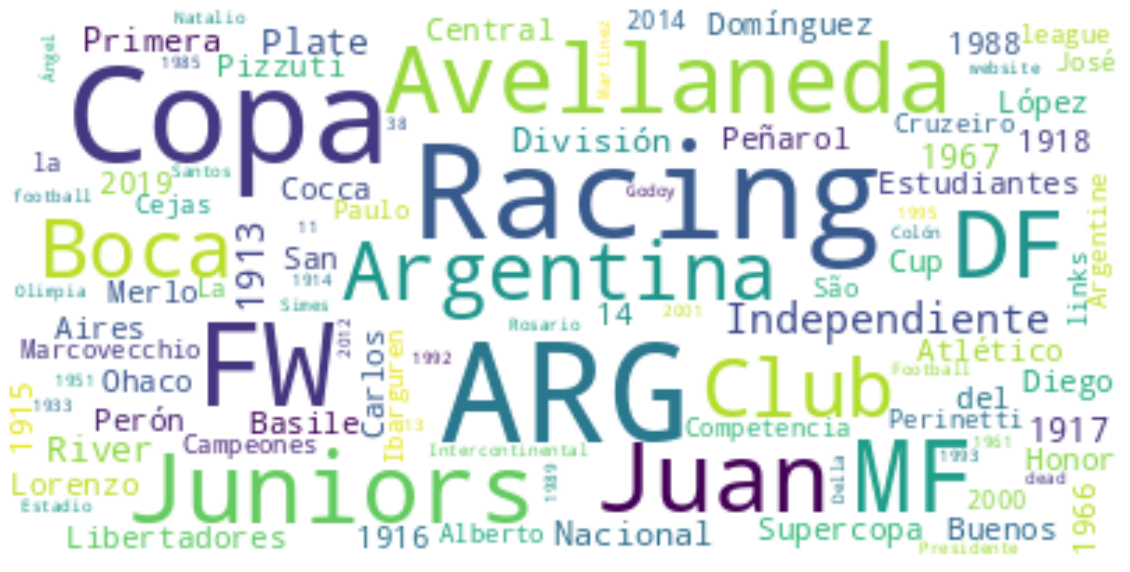

In [414]:
# Now i will show it nicely haha

d = pd.Series(df.score.values,index=df.word).to_dict()

wordcloud = WordCloud(background_color = 'white',max_font_size=50, max_words=100)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("img/" + URL.split("/")[-1] + ".png", format="png")
# plt.show()

## Now we are going to do the n-grams